In [1]:
from models.utils import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from models.diffusion_model import *

In [2]:
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn, z_dim=784))
score_model = score_model.to(device)

## size of a mini-batch
batch_size =  64 #@param {'type':'integer'}


dataset = MNIST('../data/', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [3]:
dataset = MNIST('../data/', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [4]:
from torchvision.utils import make_grid
from models.samplers import *

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

from models.jscc import *
autoencoder = Autoencoder(in_channels=1,
                c=8,
                snr=0)
autoencoder.load_state_dict(torch.load('./checkpoints/jscc.pt', map_location=device))

autoencoder.to(device)
score_model.to(device)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

In [5]:
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.functional import structural_similarity_index_measure

ssim = structural_similarity_index_measure
psnr = PeakSignalNoiseRatio().to('cuda')

jpeg_ssim = 0
jpeg_psnr = 0
diff_ssim = 0
diff_psnr = 0

In [6]:
qualities = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
comp_ratio = []
ssim_jpeg_list = []
ssim_diff_list = []
psnr_jpeg_list = []
psnr_diff_list = []
# lpips_jpeg_list = []
# lpips_diff_list = []
select_t = 0.3 #@param {'type':'number'}

for quality in qualities:
    i = 0
    num_items = 0
    # jpeg_lpips = 0
    jpeg_ssim = 0
    jpeg_psnr = 0
    # diff_lpips = 0
    diff_ssim = 0
    diff_psnr = 0
    _, (x, y) = next(enumerate(data_loader))
    imgs_int = (x.clone().detach()*255).to(dtype=torch.uint8)
    # compute the compression ratio
    comp_ratio.append(torchvision.io.encode_jpeg(imgs_int[0].cpu(), quality=quality).shape[0]/784)
    with torch.no_grad():
        for x, y in data_loader:
            i += 1
            x = x.to(device)
            num_items += x.shape[0]
            # decode x with jpeg, range 0-1
            x_jpeg = jpeg_compress(x, quality=quality).to(device)
            # decode with diffusion model
            x_ = forward_process(x, marginal_prob_std_fn, 500, device=device, end_t=select_t, only_final=True)
            jscc_x = autoencoder(x_)
            # range: 0-1
            samples = sampler(score_model,
                    marginal_prob_std_fn,
                    diffusion_coeff_fn,
                    sample_batch_size,
                    device=device,
                    x=jscc_x.detach(),
                    z=x_jpeg.reshape(x_jpeg.shape[0], -1),
                    start_t=select_t,
                    ).type_as(x)
            samples = samples.clamp(0.0, 1.0)
            # compute the metrics
            # jpeg_lpips += lpips(x_jpeg, x).item()
            # diff_lpips += lpips(samples, x).item()

            jpeg_ssim += ssim(x_jpeg, x).item()
            diff_ssim += ssim(samples, x).item()

            jpeg_psnr += psnr(x_jpeg, x).item()
            diff_psnr += psnr(samples, x).item()

            if i % 20 == 0:
                print(f'Iter: {i}, Diff Quality: {quality}, SSIM: {diff_ssim/i:.4f}, PSNR: {diff_psnr/i:.4f}')
                print(f'Iter: {i}, JPEG Quality: {quality}, SSIM: {jpeg_ssim/i:.4f}, PSNR: {jpeg_psnr/i:.4f}')
            if i > 100:
                break
    # Print the averaged training loss so far.
    ssim_jpeg_list.append(jpeg_ssim/i)
    ssim_diff_list.append(diff_ssim/i)
    psnr_jpeg_list.append(jpeg_psnr/i)
    psnr_diff_list.append(diff_psnr/i)
    # lpips_jpeg_list.append(jpeg_lpips/num_items)
    # lpips_diff_list.append(diff_lpips/num_items)

/home/wangxu/Documents/projects/improved-jpeg-via-diffusion-models/models/diffusion_model.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/home/wangxu/Documents/projects/improved-jpeg-via-diffusion-models/models/diffusion_model.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Iter: 20, Diff Quality: 1, SSIM: 0.7829, PSNR: 20.4960
Iter: 20, JPEG Quality: 1, SSIM: 0.7513, PSNR: 18.8884
Iter: 40, Diff Quality: 1, SSIM: 0.7863, PSNR: 20.5055
Iter: 40, JPEG Quality: 1, SSIM: 0.7541, PSNR: 18.8593
Iter: 60, Diff Quality: 1, SSIM: 0.7862, PSNR: 20.4875
Iter: 60, JPEG Quality: 1, SSIM: 0.7537, PSNR: 18.8382
Iter: 80, Diff Quality: 1, SSIM: 0.7858, PSNR: 20.4825
Iter: 80, JPEG Quality: 1, SSIM: 0.7535, PSNR: 18.8457
Iter: 100, Diff Quality: 1, SSIM: 0.7855, PSNR: 20.4704
Iter: 100, JPEG Quality: 1, SSIM: 0.7528, PSNR: 18.8358
Iter: 20, Diff Quality: 2, SSIM: 0.7886, PSNR: 20.4576
Iter: 20, JPEG Quality: 2, SSIM: 0.7549, PSNR: 18.8018
Iter: 40, Diff Quality: 2, SSIM: 0.7856, PSNR: 20.4764
Iter: 40, JPEG Quality: 2, SSIM: 0.7531, PSNR: 18.8261
Iter: 60, Diff Quality: 2, SSIM: 0.7869, PSNR: 20.4498
Iter: 60, JPEG Quality: 2, SSIM: 0.7548, PSNR: 18.8166
Iter: 80, Diff Quality: 2, SSIM: 0.7867, PSNR: 20.4561
Iter: 80, JPEG Quality: 2, SSIM: 0.7547, PSNR: 18.8217
Iter: 10

In [18]:
ssim_jpeg_list = [0.7527,
  0.7548,
  0.7608,
  0.7707,
  0.7880,
  0.8085,
  0.8127,
  0.8258,
  0.8292,
  0.8319]

ssim_diff_list = [0.7854,
  0.7868,
  0.7969,
  0.8074,
  0.8098,
  0.8223,
  0.8257,
  0.8300,
  0.8378,
  0.8404]

In [29]:
psnr_jpeg_list = [18.8271,
  18.8364,
  19.3633,
  20.0757,
  20.5261,
  21.2845,
  21.8268,
  22.1790,
  22.4879,
  22.5301]

psnr_diff_list = [20.4525,
  20.4799,
  21.0669,
  21.6561,
  21.9831,
  22.2463,
  22.3862,
  22.5154,
  22.6728,
  22.7423]

In [27]:
comp_ratio = [0.45938775510204084,
 0.4604591836734694,
 0.46683673469387754,
 0.4770408163265306,
 0.48086734693877553,
 0.4885204081632653,
 0.49489795918367346,
 0.5121326530612245,
 0.5197551020408163,
 0.5229591836734694,]

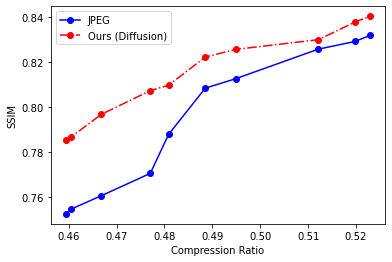

In [36]:
import matplotlib.pyplot as plt

plt.plot(comp_ratio, ssim_jpeg_list, 'bo-', label='JPEG')
plt.plot(comp_ratio, ssim_diff_list, 'ro-.', label='Ours (Diffusion)')
plt.xlabel('Compression Ratio')
plt.ylabel('SSIM')
plt.legend()
plt.savefig('ssim.png')

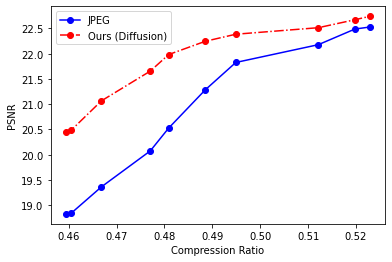

In [37]:
plt.plot(comp_ratio, psnr_jpeg_list, 'bo-', label='JPEG')
plt.plot(comp_ratio, psnr_diff_list, 'ro-.', label='Ours (Diffusion)')
plt.xlabel('Compression Ratio')
plt.ylabel('PSNR')
plt.legend()
plt.savefig('psnr.png')